In [ ]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from ekf_vindy.plotting import plotter
from ekf_vindy.ekf.utils import add_noise_with_snr
from scipy.integrate import odeint

seed = 29

# Setup torch device and dtype

np.random.seed(seed)

/home/carlos/.cache/pypoetry/virtualenvs/vindy-MoRRIXoN-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.


In [4]:
torch_config.setup_device_and_type()

PyTorch device set to cpu and dtype set to torch.float32.


# Roessler ODE with VINDy

We will use the varional version of SINDy to learn the following dynamical system:

$$
\begin{align}
\dot{z}_1 &= -z_2 - z_3, \\
\dot{z}_2 &= z_1 + a z_2, \\
\dot{z}_3 &= b + z_3 (z_1 - c),
\end{align}
$$

where $ a = 0.2, b = 0.2, c = 5.7$. Notice that in the first equation we will learn the coefficients $1$ as well. Let's define the vector field and generate training data.

In [5]:
def roessler(x, t, params):
    a = params['a']
    b = params['b']
    c = params['c']
    
    x, y, z =  x[0], x[1], x[2]
    return [-y - z, x + a * y, b + z * (x - c)]

Let's generate trajectories and add some noise to them.

In [6]:
params = {
    'a' : 0.2,
    'b' : 0.2,
    'c' : 5.7}

dt = 0.012 # Roughly what they use in VENI-VINDy-VICI
mean_ic = np.array([-5, -5, 0])
std = 1
n_train = 30
x_0 = np.random.randn(n_train, 3) * std + mean_ic
time_instances = np.arange(0, 24, dt)
x_train = []

for i in range(n_train):
    sol = odeint(roessler, x_0[i, :], time_instances, args=(params,))
    x_train.append(sol)
    
model = ps.SINDy(feature_names=['u1', 'u2', 'u3'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))
model.fit(x_train, t=0.012, multiple_trajectories=True)
model.print()

x_train_np = np.stack(x_train, axis=0)     # shape: (n_train, T, 2)
x_train = torch.from_numpy(x_train_np).to(device = torch_config.device, dtype = torch_config.dtype)
x_train.shape


(u1)' = -1.000 u2 + -1.000 u3
(u2)' = 1.000 u1 + 0.200 u2
(u3)' = 0.200 1 + -5.696 u3 + 0.999 u1 u3


torch.Size([30, 2000, 3])

Compute derivatives by hand

In [7]:
dt = torch.tensor(dt, device=torch_config.device, dtype=torch_config.dtype)
# central
dxdt_mid = (x_train[:, 2:, :] - x_train[:, :-2, :]) / (2 * dt)

# forward difference for first point
dxdt_0 = (x_train[:, 1:2, :] - x_train[:, 0:1, :]) / dt

# backward difference for last point
dxdt_T = (x_train[:, -1:, :] - x_train[:, -2:-1, :]) / dt

# concatenate to get shape (N, T, 2)
dxdt = torch.cat([dxdt_0, dxdt_mid, dxdt_T], dim=1)

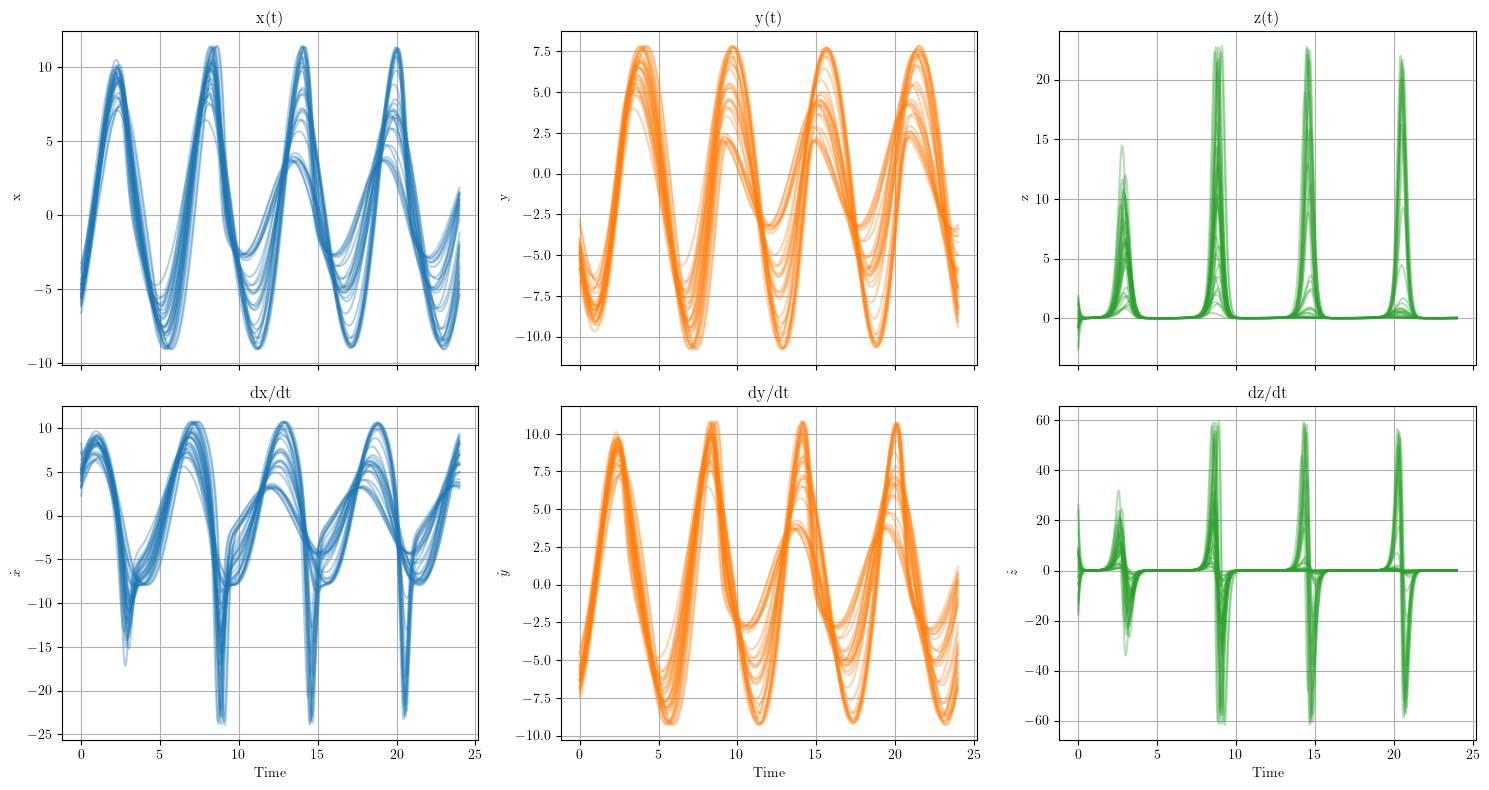

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)

state_colors = ['tab:blue', 'tab:orange', 'tab:green']
# deriv_colors = ['tab:red', 'tab:purple', 'tab:brown']
names = ['x', 'y', 'z']

# -------- ROW 1: STATES x, y, z --------
for dim in range(3):
    ax = axes[0, dim]
    for i in range(n_train):
        ax.plot(
            time_instances,
            x_train[i, :, dim].cpu().numpy(),
            alpha=0.35,
            color=state_colors[dim]
        )
    ax.set_title(f"{names[dim]}(t)")
    ax.set_ylabel(names[dim])
    ax.grid(True)

# -------- ROW 2: DERIVATIVES xdot, ydot, zdot --------
for dim in range(3):
    ax = axes[1, dim]
    for i in range(n_train):
        ax.plot(
            time_instances,
            dxdt[i, :, dim].cpu().numpy(),
            alpha=0.35,
            color=state_colors[dim]
        )
    ax.set_title(f"d{names[dim]}/dt")
    ax.set_ylabel(rf"$\dot{{{names[dim]}}}$")  # mathtext
    ax.set_xlabel("Time")
    ax.grid(True)

plt.tight_layout()
plt.show()

Now we set up VINDy and train...

In [18]:
from ekf_vindy.vindy.layers.vindy_layer import VINDyLayer
from ekf_vindy.vindy.training_loops import train_vindy
from ekf_vindy.vindy import torch_config

N, T, n = x_train.shape

z_train = x_train.reshape(N*T, n)
dzdt_train = dxdt.reshape(N*T, n)


vindy_layer = VINDyLayer(latent_dim=3,
                         n_parameters=0,
                         poly_order=3,
                         parameter_names=None,
                         distribution_initialization='ones',
                         prior_loc=0.0,
                         prior_log_scale=3)

trained_vindy = train_vindy(
    vindy_layer,
    z_train,
    dzdt_train,
    n_epochs = 500,
    lr = 1e-3,
    huber_weight= 1.0,
    kl_weight= 5e-3
)

[0] loss=6.0733e+02   mse=6.0699e+02   L1=6.8608e+01
[50] loss=5.7595e+02   mse=5.7562e+02   L1=6.5976e+01
[100] loss=5.4457e+02   mse=5.4426e+02   L1=6.3380e+01
[150] loss=5.1319e+02   mse=5.1289e+02   L1=6.0823e+01
[200] loss=4.8182e+02   mse=4.8153e+02   L1=5.8306e+01
[250] loss=4.5044e+02   mse=4.5016e+02   L1=5.5829e+01
[300] loss=4.1906e+02   mse=4.1880e+02   L1=5.3394e+01
[350] loss=3.8769e+02   mse=3.8743e+02   L1=5.1002e+01
[400] loss=3.5631e+02   mse=3.5607e+02   L1=4.8653e+01
[450] loss=3.2494e+02   mse=3.2471e+02   L1=4.6350e+01


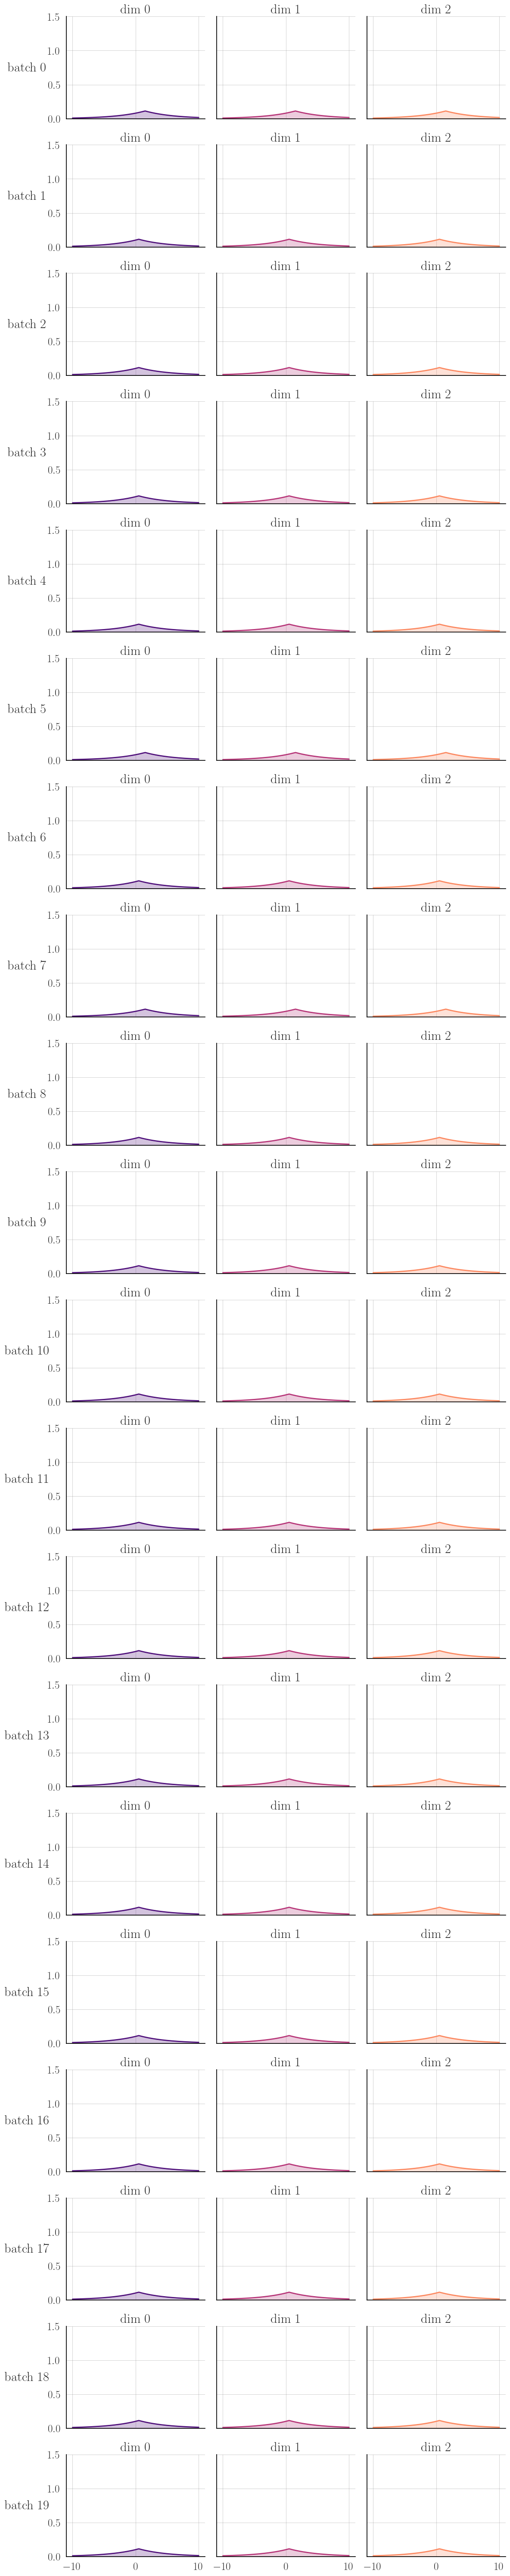

In [19]:
from ekf_vindy.plotting.plotter import plot_pdf

fig, axes = plot_pdf(
    *trained_vindy.big_xi_distribution.evaluate_pdf(),
    ylim=(0, 1.5),
    palette="magma",
    label_size="large"
)
plt.show()